# Table of Contents
* [pairing images and annotations](#pairing-images-and-annotations)
* [sampling images](#sampling-images)


In [1]:
%%capture
from __future__ import division
import numpy as np
import pandas as pd
import scipy.stats as st
import itertools
import math
from collections import Counter, defaultdict
%load_ext autoreload
%autoreload 2

In [2]:
import os
import cv2
import PIL.Image as Image

In [3]:
image_path_prefix = '../data/small_table_training/'
anno_path_prefix = '../data/exp_nicks_data/table-research/ground_truth/alternate/'

In [4]:
image_files = os.listdir(image_path_prefix)

In [5]:
anno_files = os.listdir(anno_path_prefix)

# pairing images and annotations

In [10]:
image_bases = [''.join(f.split('.')[:-1]) for f in image_files]
anno_bases = [''.join(f.split('.')[:-2]) for f in anno_files]

In [11]:
images_with_anno  = [f  for f in image_files if ''.join(f.split('.')[:-1]) in anno_bases]

In [12]:
bases_intersection = set(image_bases).intersection(set(anno_bases))

In [13]:
len(bases_intersection)

97

In [14]:
len(anno_bases)

97

In [15]:
len(anno_bases)

97

images missing annotations

In [16]:
set(image_bases[:100]).difference(set(anno_bases))

{'029-grid6', '036-table_1(1)', '050-grid15'}

# sampling images

In [20]:
sample_n = 30

In [21]:
sample_image = images_with_anno[sample_n]

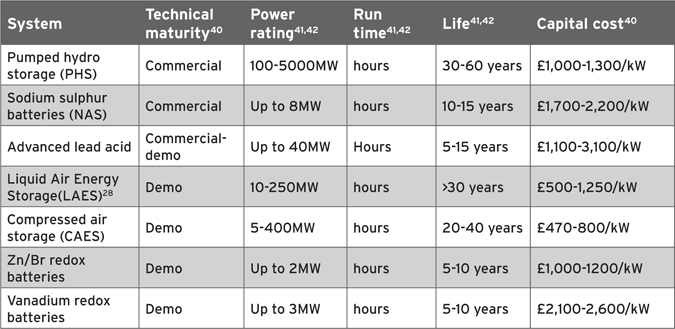

In [22]:
Image.open(image_path_prefix + sample_image)

In [23]:
with open(anno_path_prefix + anno_files[sample_n]) as f:
    sample_anno = f.readlines()

split_lines = [l.split(',', maxsplit=4) for l in sample_anno]

In [24]:
split_lines

[['3', '3', '136', '42', 'System\n'],
 ['142', '3', '96', '41', 'Technical maturity40\n'],
 ['247', '3', '98', '41', 'Power rating41,42\n'],
 ['354', '5', '75', '38', 'Run time41,42\n'],
 ['438', '2', '90', '42', 'Life41,42\n'],
 ['536', '1', '135', '42', 'Capital cost40\n'],
 ['3', '47', '134', '36', 'Pumped hydro storage (PHS)\n'],
 ['2', '84', '136', '42', 'Sodium sulphur batteries (NAS)\n'],
 ['2', '127', '136', '37', 'Advanced lead acid\n'],
 ['1', '166', '135', '39', 'Liquid Air Energy Storage(LAES)28\n'],
 ['2', '208', '136', '36', 'Compressed air storage (CAES)\n'],
 ['0', '247', '138', '40', 'Zn/Br redox batteries\n'],
 ['2', '290', '134', '37', 'Vanadium redox batteries\n'],
 ['140', '46', '103', '36', 'Commercial\n'],
 ['140', '85', '103', '40', 'Commercial\n'],
 ['143', '128', '99', '38', 'Commercial- demo\n'],
 ['142', '168', '101', '39', 'Demo\n'],
 ['143', '210', '103', '39', 'Demo\n'],
 ['140', '249', '106', '42', 'Demo\n'],
 ['143', '293', '102', '37', 'Demo\n'],
 ['24

In [25]:
[len(l) for l in split_lines]

[5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5]

In [26]:
split_lines[:3]

[['3', '3', '136', '42', 'System\n'],
 ['142', '3', '96', '41', 'Technical maturity40\n'],
 ['247', '3', '98', '41', 'Power rating41,42\n']]

In [27]:
sample_image

'011-Table-3.5-Grid-storage-technologies-compared.jpg'

# Hough lines

In [479]:
easy_image = '/Users/schwenk/wrk/tableparse/vision-tableparse/examples/example_1.png'

In [484]:
# img = cv2.imread(image_path_prefix + sample_image)
img = cv2.imread(easy_image)

gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)


edges = cv2.Canny(gray, 100, 200, apertureSize=3, L2gradient=1)

minLineLength = 30
maxLineGap = 10
lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 120, minLineLength=10, maxLineGap=2)
for x in range(0, len(lines)):
    for x1,y1,x2,y2 in lines[x]:
        cv2.line(img,(x1,y1),(x2,y2),(0,255,0),2)

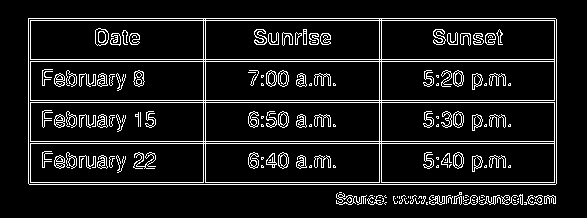

In [485]:
Image.fromarray(edges)

In [486]:
lines.shape

(18, 1, 4)

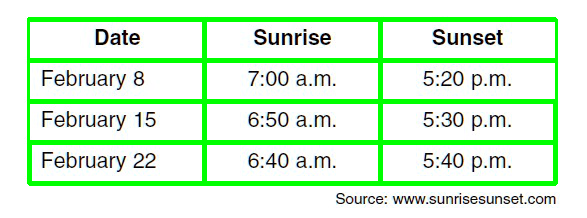

In [487]:
Image.fromarray(img)

In [490]:
import cv2
import numpy as np
import os.path
from collections import defaultdict


def ik(x, y):
    return '.'.join([str(x), str(y)])


def boxes_from_intersections(image_bw, h_intersections, v_intersections, all_intersections):
    boxes = []
    for x_i, y_i in all_intersections:
        i_key = ik(x_i, y_i)
        nearest_y = 99999999
        nearest_x = 99999999
        found_point = False
        for x_j, y_j in all_intersections:
            j_key = ik(x_j, y_j)
            if x_j > x_i and y_j > y_i and (h_intersections[i_key] & v_intersections[j_key]) and \
               (v_intersections[i_key] & h_intersections[j_key]) and x_j <= nearest_x and y_j <= nearest_y:
                nearest_x = x_j
                nearest_y = y_j
                found_point = True

        if found_point:
            # x, y, width, height, text
            height = nearest_y - y_i
            width = nearest_x - x_i
            avg_color = (np.average(image_bw[y_i:nearest_y, x_i:nearest_x]))
            if (width <= 15 or height <= 15) and avg_color == 0.0:
                continue
            boxes.append((x_i, y_i, width, height, []))

    return boxes


def get_intersections(img, horiz_lines, vert_lines):
    h_intersections = defaultdict(set)
    v_intersections = defaultdict(set)
    all_intersections = set()

    for h_x1, h_y1, h_x2, h_y2 in horiz_lines:
        intersect_set = set()
        for v_x1, v_y1, v_x2, v_y2 in vert_lines:
            if v_x1 >= h_x1 and v_x1 <= h_x2 and v_y1 <= h_y1 and v_y2 >= h_y1:
                i_key = ik(v_x1, h_y1)
                intersect_set.add(i_key)

        if len(intersect_set) > 2:
            for s in intersect_set:
                all_intersections.add(tuple(map(int, s.split('.'))))
                h_intersections[s] = intersect_set

    for v_x1, v_y1, v_x2, v_y2 in vert_lines:
        intersect_set = set()
        for h_x1, h_y1, h_x2, h_y2 in horiz_lines:
            if v_x1 >= h_x1 and v_x1 <= h_x2 and v_y1 <= h_y1 and v_y2 >= h_y1:
                i_key = ik(v_x1, h_y1)
                intersect_set.add(i_key)

        if len(intersect_set) > 2:
            for s in intersect_set:
                all_intersections.add(tuple(map(int, s.split('.'))))
                v_intersections[s] = intersect_set

    return h_intersections, v_intersections, list(all_intersections)

def supress_lines(lines):
    new_lines = []
    for i, line_a in enumerate(lines):
        suppressed = False
        for j, line_b in enumerate(lines):
            if i >= j:
                continue

            if line_a[0] == line_a[2]:
                min_x = min([line_a[1], line_b[1]])
                max_x = max([line_a[3], line_b[3]])
                intersection = min([line_a[3], line_b[3]]) - max([line_a[1], line_b[1]])
                delta = abs(line_a[0] - line_b[0])

            else:
                min_x = min([line_a[0], line_b[0]])
                max_x = max([line_a[2], line_b[2]])
                intersection = min([line_a[2], line_b[2]]) - max([line_a[0], line_b[0]])
                delta = abs(line_a[1] - line_b[1])

            if intersection > 0 and (intersection/float(max_x - min_x)) > 0.5 and delta < 8:
                suppressed = True
                break

        if not suppressed:
            new_lines.append(line_a)

    return new_lines

In [604]:
def get_boxes(image_name, base_path):
    horiz_lines = []
    vert_lines = []
    img = cv2.imread(os.path.join(base_path, image_name))
    #img =  cv2.resize(img,(2*img.shape[1], 2*img.shape[0]), interpolation = cv2.INTER_CUBIC)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    (thresh, im_bw) = cv2.threshold(gray, 128, 255, cv2.THRESH_OTSU)

    edges = cv2.Canny(gray, 50, 250, apertureSize=3)
#     edges = cv2.Canny(gray, 100, 200, apertureSize=3, L2gradient=1)
#     return Image.fromarray(edges)
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 200, minLineLength=20, maxLineGap=3)
#     lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 120, minLineLength=100, maxLineGap=2)
    if lines is None:
        lines = []

    for info in lines:
        x1, y1, x2, y2 = info[0]
        if y2 < y1:
            y1 = info[0][3]
            y2 = info[0][1]

        # horizontal line
        offsets = [-1, 0, 1]
        if y1 - y2 == 0:
            avg_above = avg_below = 256
            avg_center = np.average(gray[y1:y2 + 1, x1:x2 + 1])

            if y1 > 0:
                avg_above = np.average(gray[y1 - 1:y2, x1:x2 + 1])

            if y2 + 1 < gray.shape[0]:
                avg_below = np.average(gray[y1 + 1:y2 + 2, x1:x2 + 1])

            # assuming black lines, could do something to check for background color

            # this occurs from edges detected in gray areas that aren't cell boundaries
            if np.min([avg_above, avg_center, avg_below]) > 192:
                continue

            y1 += offsets[np.argmin([avg_above, avg_center, avg_below])]

            y2 = y1

            while x2 + 1 < im_bw.shape[1] and abs(im_bw[y1:y2 + 1, x2 + 1:x2 + 2][0,0] - np.average(im_bw[y1:y2 + 1, x1:x2 + 1])) < 16:
                x2 += 1

            while x1 > 0 and abs(im_bw[y1:y2 + 1, x1 - 1:x1][0,0] - np.average(im_bw[y1:y2 + 1, x1:x2 + 1])) < 16:
                x1 -= 1

            horiz_lines.append((x1, y1, x2, y2))
        elif x1 - x2 == 0:
            avg_right = avg_left = 256
            avg_center = np.average(gray[y1:y2 + 1, x1:x2 + 1])

            if x1 > 0:
                avg_left = np.average(gray[y1:y2 + 1, x1 - 1:x2])

            if x2 + 1 < gray.shape[1]:
                avg_right = np.average(gray[y1:y2 + 1, x1 + 1: x2 + 2])

            x1 += offsets[np.argmin([avg_left, avg_center, avg_right])]

            x2 = x1

            while y2 + 1 < im_bw.shape[0] and abs(im_bw[y2 + 1:y2 + 2, x1:x2 + 1][0,0] - np.average(im_bw[y1:y2 + 1, x1:x2 + 1])) < 16:
                y2 += 1

            while y1 > 0 and abs(im_bw[y1 - 1:y1, x1:x2 + 1][0,0] - np.average(im_bw[y1:y2 + 1, x1:x2 + 1])) < 16:
                y1 -= 1

            vert_lines.append((x1, y1, x2, y2))
    horiz_lines = supress_lines(horiz_lines)
    vert_lines = supress_lines(vert_lines)

    sorted_h_lines = sorted(horiz_lines, key=lambda l: l[1])
    sorted_v_lines = sorted(vert_lines, key=lambda l: l[0])
    h_intersections, v_intersections, all_intersections = get_intersections(img, sorted_h_lines, sorted_v_lines)
    return boxes_from_intersections(im_bw, h_intersections, v_intersections, all_intersections)

In [605]:
def random_color():
    import random
    return random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)

def draw_detections(img_path, found_cells):
    colors = [
        (255, 0, 0),
        (0, 255, 0),
        (0, 0, 255),
        (255, 255, 0),
        (0, 255, 255),
        (255, 0, 255),

        (128, 0, 0),
        (0, 128, 0),
        (0, 0, 128),
        (128, 128, 0),
        (0, 128, 128),
        (128, 0, 128),

        (255, 128, 0),
        (0, 128, 255),
        (128, 255, 0),
        (0, 255, 128),
        (255, 0, 128),
        (128, 0, 255)]
    
    image = cv2.imread(img_path)
    color_counter = 0
    for cell in found_cells:
        start_x = cell[0] 
        start_y = cell[1]
        end_x = cell[0] + cell[2]
        end_y = cell[1] + cell[3]
        cv2.rectangle(image, (start_x, start_y), (end_x, end_y), color=random_color(), thickness=2)
        color_counter += 1
    return Image.fromarray(image)

In [606]:
old_boxes = get_boxes(sample_image, image_path_prefix)

In [607]:
new_boxes = get_boxes(sample_image, image_path_prefix)

In [608]:
len(new_boxes)

28

In [609]:
import random

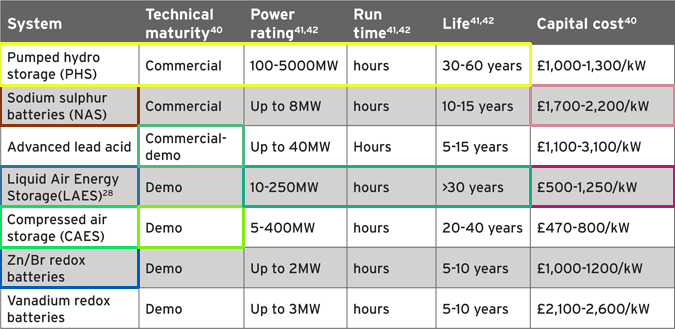

In [614]:
draw_detections(image_path_prefix + sample_image, random.sample(boxes, 10))